Utilizando el código del problema anterior analice que pasa cuando se utiliza\
una capa densa con la información de los pixels permutada espacialmente y que\
pasa si en lugar de capa densa se usa una convolucional donde en las capas\
convolucional se asume un prior de forma espacial. Compare los resultados del\
problema anterior (densa y conv. para las curvas training y testing) con los\
resultados obtenidos haciendo la permutaciones espaciales de los pixeles. 

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype(float)/255
x_test = x_test.astype(float)/255

x_train.shape, x_test.shape

11501568/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28))

Permuto espacialmente los datos

In [ ]:
permutation = np.random.permutation(28*28)

x_train_perm = x_train.reshape(x_train.shape[0], -1)
x_train_perm = x_train_perm[:,permutation]
x_train_perm = x_train_perm.reshape(x_train.shape)
x_test_perm = x_test.reshape(x_test.shape[0], -1)
x_test_perm = x_test_perm[:,permutation]
x_test_perm = x_test_perm.reshape(x_test.shape)

x_test_perm.shape

(10000, 28, 28)

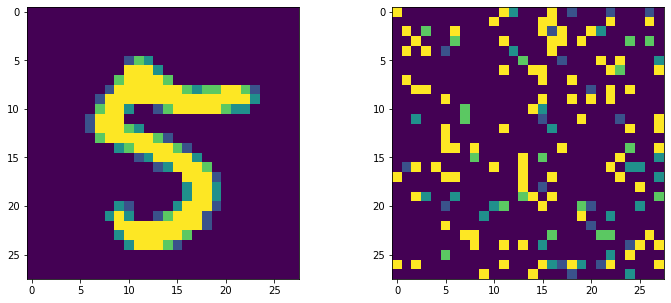

In [ ]:
idx = 512
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax1.imshow(x_train[idx])
ax2.imshow(x_train_perm[idx]);

In [ ]:
def plot(hist):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,4))
    ax1.plot(hist.history['loss'], label='CCE')
    ax1.plot(hist.history['val_loss'], label='val_CCE')
    ax1.set_xlabel('Epocas', fontsize=15)
    ax1.set_ylabel('Loss', fontsize=15)
    ax1.legend(loc='best')

    ax2.plot(hist.history['sparse_categorical_accuracy'], label='acc')
    ax2.plot(hist.history['val_sparse_categorical_accuracy'], label='val_acc')
    ax2.set_xlabel('Epocas', fontsize=15)
    ax2.set_ylabel('Accuracy', fontsize=15)
    ax2.legend(loc='best')

    fig.tight_layout()
    plt.show()
    return None

Primero la red densa. Mi hipotesis es que no va a cambiar nada

In [ ]:
keras.backend.clear_session()

reg = keras.regularizers.L2(l2=1e-4)

input = keras.layers.Input(shape=(28,28))
flat = keras.layers.Flatten()(input)

l1 = keras.layers.Dense(256, activation='relu', kernel_regularizer=reg)(flat)
drop1 = keras.layers.Dropout(rate=.2)(l1)

l2 = keras.layers.Dense(128, activation='relu', kernel_regularizer=reg)(drop1)
drop2 = keras.layers.Dropout(rate=.2)(l2)

l3 = keras.layers.Dense(10, activation='relu', kernel_regularizer=reg)(drop2)

output = keras.layers.Dense(784, activation='sigmoid', kernel_regularizer=reg)(l3)

model = keras.models.Model(inputs=input, outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1290  

In [ ]:
opt = keras.optimizers.Adam(learning_rate=.005)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

hist = model.fit(x_train_perm, y_train, validation_data=(x_test_perm, y_test), 
                 epochs=10, batch_size=128, verbose=2)

Epoch 1/10
469/469 - 5s - loss: 0.5395 - sparse_categorical_accuracy: 0.8707 - val_loss: 0.2583 - val_sparse_categorical_accuracy: 0.9510 - 5s/epoch - 10ms/step
Epoch 2/10
469/469 - 4s - loss: 0.2873 - sparse_categorical_accuracy: 0.9462 - val_loss: 0.2451 - val_sparse_categorical_accuracy: 0.9598 - 4s/epoch - 8ms/step
Epoch 3/10
469/469 - 4s - loss: 0.2724 - sparse_categorical_accuracy: 0.9539 - val_loss: 0.2326 - val_sparse_categorical_accuracy: 0.9670 - 4s/epoch - 9ms/step
Epoch 4/10
469/469 - 4s - loss: 0.2618 - sparse_categorical_accuracy: 0.9584 - val_loss: 0.2266 - val_sparse_categorical_accuracy: 0.9688 - 4s/epoch - 8ms/step
Epoch 5/10
469/469 - 4s - loss: 0.2627 - sparse_categorical_accuracy: 0.9578 - val_loss: 0.2151 - val_sparse_categorical_accuracy: 0.9726 - 4s/epoch - 8ms/step
Epoch 6/10
469/469 - 4s - loss: 0.2561 - sparse_categorical_accuracy: 0.9590 - val_loss: 0.2290 - val_sparse_categorical_accuracy: 0.9690 - 4s/epoch - 8ms/step
Epoch 7/10
469/469 - 4s - loss: 0.2602 

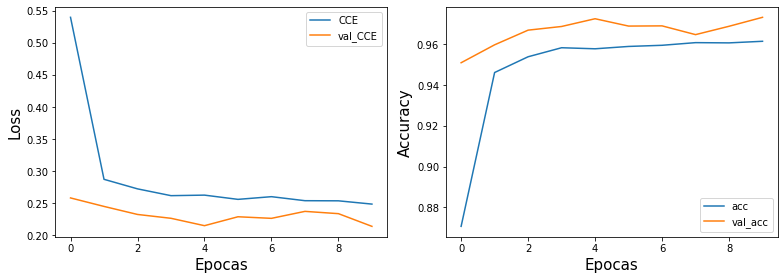

In [ ]:
plot(hist)

Ahora la red convolucional. Aca si es importante la info espacial (creo)

In [ ]:
keras.backend.clear_session()

reg = keras.regularizers.L2(l2=1e-4)
drop_r = 0.1

input = keras.layers.Input(shape=(28,28,1))

l1 = keras.layers.Conv2D(32, 5, activation='relu', padding='same')(input)
pool1 = keras.layers.MaxPooling2D()(l1)
drop1 = keras.layers.Dropout(rate=drop_r)(pool1)

l2 = keras.layers.Conv2D(32, 3, activation='relu', padding='same')(drop1)
pool2 = keras.layers.MaxPooling2D()(l2)
drop2 = keras.layers.Dropout(rate=drop_r)(pool2)

l3 = keras.layers.Conv2D(64, 2, activation='relu', padding='same')(drop2)
pool3 = keras.layers.MaxPooling2D()(l3)
drop3 = keras.layers.Dropout(rate=drop_r)(pool3)

flat = keras.layers.Flatten()(drop3)

#le voy a sacar la capa densa para no hacer trampa
#l4 = keras.layers.Dense(50, activation='relu', kernel_regularizer=reg)(flat)
#drop4 = keras.layers.Dropout(rate=drop_r)(l4)

output = keras.layers.Dense(10, activation='sigmoid', kernel_regularizer=reg)(flat)

model = keras.models.Model(inputs=input, outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                         

In [ ]:
opt = keras.optimizers.Adam(learning_rate=.001)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

hist = model.fit(x_train_perm, y_train, validation_data=(x_test_perm, y_test), 
                 epochs=15, batch_size=256, verbose=1)

Epoch 1/15
235/235 [==============================] - 65s 276ms/step - loss: 1.2626 - sparse_categorical_accuracy: 0.5871 - val_loss: 0.5215 - val_sparse_categorical_accuracy: 0.8408
Epoch 2/15
235/235 [==============================] - 65s 276ms/step - loss: 0.5241 - sparse_categorical_accuracy: 0.8361 - val_loss: 0.3422 - val_sparse_categorical_accuracy: 0.8968
Epoch 3/15
235/235 [==============================] - 65s 275ms/step - loss: 0.3921 - sparse_categorical_accuracy: 0.8802 - val_loss: 0.2721 - val_sparse_categorical_accuracy: 0.9190
Epoch 4/15
235/235 [==============================] - 64s 273ms/step - loss: 0.3307 - sparse_categorical_accuracy: 0.9000 - val_loss: 0.2358 - val_sparse_categorical_accuracy: 0.9294
Epoch 5/15
235/235 [==============================] - 64s 274ms/step - loss: 0.2901 - sparse_categorical_accuracy: 0.9121 - val_loss: 0.2105 - val_sparse_categorical_accuracy: 0.9348
Epoch 6/15
235/235 [==============================] - 64s 273ms/step - loss: 0.2603 -

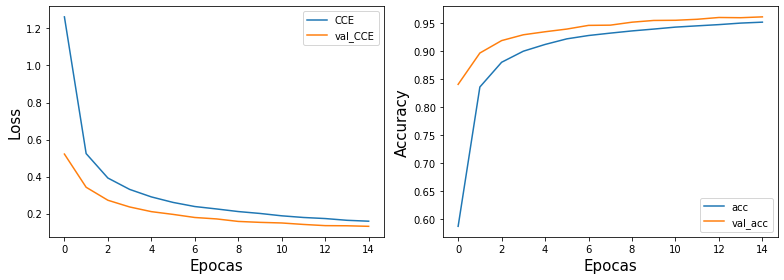

In [ ]:
plot(hist)

Bueno, baja un 3~4% la precision, me esperaba mas